In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report


In [ ]:
# Data transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 10 classes (CIFAR-10)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data).cpu()  # Move to CPU
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels.data).cpu()  # Move to CPU
                total_val_preds += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val_preds.double() / total_val_preds

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

        # Scheduler step
        scheduler.step()

        # Deep copy the model if it's the best so far
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    return model


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Move to CPU
            all_labels.extend(labels.cpu().numpy())  # Move to CPU

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch 1/10
----------
Train Loss: 1.0535 Acc: 0.6395 Val Loss: 0.8710 Val Acc: 0.7052

Epoch 2/10
----------
Train Loss: 0.7799 Acc: 0.7355 Val Loss: 0.7013 Val Acc: 0.7593

Epoch 3/10
----------
Train Loss: 0.6774 Acc: 0.7687 Val Loss: 0.7082 Val Acc: 0.7592

Epoch 4/10
----------
Train Loss: 0.6243 Acc: 0.7879 Val Loss: 0.6922 Val Acc: 0.7875

Epoch 5/10
----------
Train Loss: 0.5578 Acc: 0.8096 Val Loss: 0.5873 Val Acc: 0.8039

Epoch 6/10
----------
Train Loss: 0.5251 Acc: 0.8197 Val Loss: 0.5454 Val Acc: 0.8192

Epoch 7/10
----------
Train Loss: 0.4817 Acc: 0.8354 Val Loss: 0.6539 Val Acc: 0.7948

Epoch 8/10
----------
Train Loss: 0.3432 Acc: 0.8822 Val Loss: 0.4564 Val Acc: 0.8510

Epoch 9/10
----------
Train Loss: 0.2935 Acc: 0.9007 Val Loss: 0.4563 Val Acc: 0.8525

Epoch 10/10
----------
Train Loss: 0.2672 Acc: 0.9084 Val Loss: 0.4662 Val Acc: 0.8555

Training complete in 5m 42s
Best accuracy: 0.8555


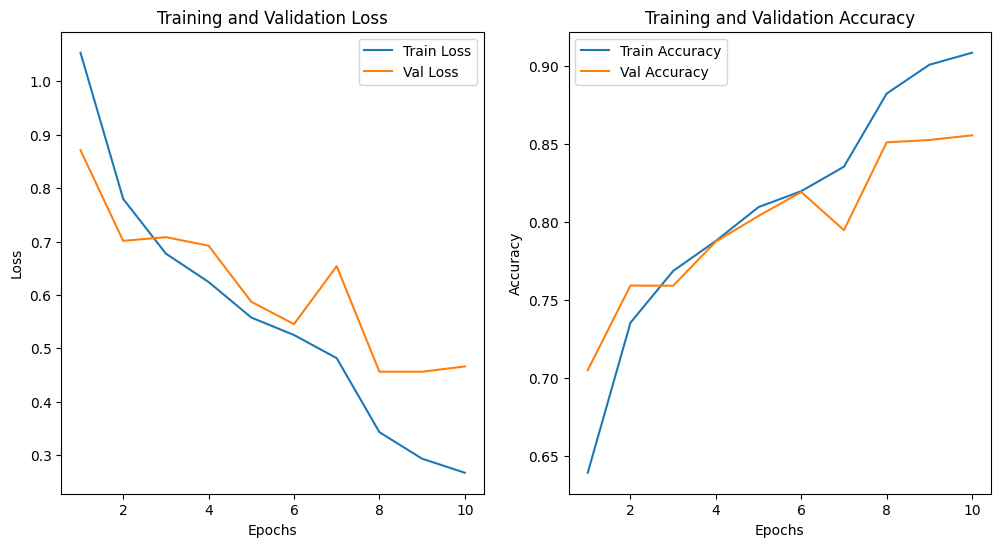

              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.93      0.90      0.91      1000
        bird       0.81      0.83      0.82      1000
         cat       0.71      0.71      0.71      1000
        deer       0.85      0.83      0.84      1000
         dog       0.77      0.79      0.78      1000
        frog       0.90      0.88      0.89      1000
       horse       0.90      0.91      0.91      1000
        ship       0.91      0.94      0.92      1000
       truck       0.89      0.90      0.89      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
# Train the model
best_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)

# Evaluate the model on the test set
evaluate_model(best_model, test_loader)


In [ ]:
# Save the model
torch.save(best_model.state_dict(), 'best_resnet18_model.pth')

# Load the model (for later use)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('best_resnet18_model.pth'))
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Make predictions on a sample image
model.eval()
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
output = model(sample_image)
_, predicted_class = torch.max(output, 1)
print(f'Predicted class: {predicted_class.item()}')


Predicted class: 3
